### BiLSTM (Bidirectional LSTM)

##### Seed For Reproducibility

In [ ]:
import tensorflow as tf
import random
import numpy as np

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

#### Loading the Dataset

In [ ]:
import pandas as pd
import json

file_path = "Sarcasm_Headlines_Dataset.json"
data = []

with open(file_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
print(df.head())


                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


#### Preprocessing + Splitting Data

In [ ]:
#keeping only necessary columns
df = df[["headline", "is_sarcastic"]]

#removing duplicates and NaN values
df = df.dropna().drop_duplicates()

#data distribution
print(df["is_sarcastic"].value_counts())

is_sarcastic
0    14951
1    11651
Name: count, dtype: int64


In [ ]:
#actual preprocessing done here
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  #lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  #remove URLs
    text = re.sub(r'\d+', '', text)  #remove numbers
    text = re.sub(r"[^\w\s]", '', text)  #remove punctuation
    tokens = word_tokenize(text)  #tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  #lemmatization & stopword removal
    return " ".join(tokens)

df["clean_text"] = df["headline"].apply(clean_text)

print(df[["headline", "clean_text"]].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swarak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/swarak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/swarak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                            headline  \
0  former versace store clerk sues over secret 'b...   
1  the 'roseanne' revival catches up to our thorn...   
2  mom starting to fear son's web series closest ...   
3  boehner just wants wife to listen, not come up...   
4  j.k. rowling wishes snape happy birthday in th...   

                                          clean_text  
0  former versace store clerk sue secret black co...  
1  roseanne revival catch thorny political mood b...  
2  mom starting fear son web series closest thing...  
3  boehner want wife listen come alternative debt...  
4   jk rowling wish snape happy birthday magical way  


In [ ]:
from sklearn.model_selection import train_test_split

X = df["clean_text"].values #gets it in array form
y = df["is_sarcastic"].values

# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: Split Temp into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
#tokenize+pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000  #max words in vocabulary

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#finding max length of a headline
max_length = max(len(seq) for seq in X_train_seq)
print(f"Max sequence length in training data: {max_length}")

#padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")


Max sequence length in training data: 26


#### GloVe Embeddings

In [ ]:
#file containing pre-trained GloVe word embeddings
glove_file_path = 'glove.6B.100d.txt'

#loading GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")


Found 400000 word vectors.


In [ ]:
#creating an embedding matrix of shape (num_words, embedding_dim)
embedding_dim = 100  #word embedding size
embedding_matrix = np.zeros((tokenizer.num_words, embedding_dim))

#fill matrix with GloVe embeddings
for word, i in tokenizer.word_index.items():
    if i < tokenizer.num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


#### Model Training

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()

#GloVe embeddings layer
model.add(Embedding(input_dim=tokenizer.num_words, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_length, 
                    trainable=True))  # setting trainable=True made model perform better in terms of lesser overfitting

#BiLSTM layers + Dropout
model.add(Bidirectional(LSTM(8, return_sequences=True))) #small number of hidden units since small dataset
model.add(Dropout(0.5))  #dropout to prevent overfitting, regularization

model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(8)))
model.add(Dropout(0.5))

#dense output layer
model.add(Dense(1, activation='sigmoid'))  #binary classification: sarcasm or not

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


/Users/swarak/Desktop/487/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.build((None, max_length))  #explicitly build the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 26, 16)         │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 26, 16)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,193 (3.85 MB)

 Trainable params: 1,010,193 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val))


Epoch 1/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6188 - loss: 0.6464 - val_accuracy: 0.7639 - val_loss: 0.4915
Epoch 2/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.7921 - loss: 0.4674 - val_accuracy: 0.8004 - val_loss: 0.4441
Epoch 3/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.8493 - loss: 0.3753 - val_accuracy: 0.8105 - val_loss: 0.4309
Epoch 4/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8829 - loss: 0.3121 - val_accuracy: 0.8098 - val_loss: 0.4681
Epoch 5/5
666/666 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.9058 - loss: 0.2676 - val_accuracy: 0.8165 - val_loss: 0.4833


#### Evaluation

In [27]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy}")


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7952 - loss: 0.4452
Test Accuracy: 0.8098459243774414


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)  #convert probabilities to binary predictions to get classification report
print(classification_report(y_test, y_pred))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1496
           1       0.82      0.72      0.77      1165

    accuracy                           0.81      2661
   macro avg       0.81      0.80      0.80      2661
weighted avg       0.81      0.81      0.81      2661



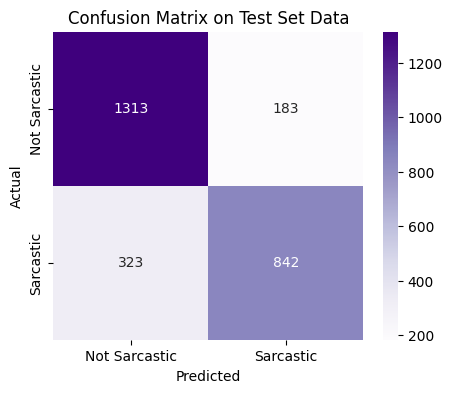

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set Data')
plt.show()

In [30]:
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
print(f"Train Accuracy: {train_accuracy}")

666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8916 - loss: 0.3002
Train Accuracy: 0.8868474364280701


In [ ]:
y_pred = model.predict(X_train_padded)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_train, y_pred))

666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11960
           1       0.97      0.87      0.91      9321

    accuracy                           0.93     21281
   macro avg       0.93      0.92      0.93     21281
weighted avg       0.93      0.93      0.93     21281

